<h1 style="font-size: 2.5em; font-weight: bold; margin-top: 0.5em; margin-bottom: 0.5em;">
 Assignment 6: Advanced topics in regression</h1> 

**In this assignment, we will:**
- study how the estimated weights of a regression model change when introducing a correlated regressor, and understand what that means for **introducing nuisance regressors**
- study why a **regression model cannot include colinear regressors**
- see how we **detect colinear or strongly correlated regressors** that could affect estimation of weights, using the **Variance Inflation Factor**
- study how we can determine in advance if our sample size is adequate to find a statistical significant effect, using **simulation-based power analysis**

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 
You can prepare for the assignment by watching the following videos: 
    
<li> <a href="https://www.youtube.com/watch?v=TA5UJYRyju0">this video</a> on multicollinearity and the Variance Inflation Factor. You can also have a look at <a href="https://www.youtube.com/watch?v=Cba9LJ9lS8s">this other video</a> which presents the same concept at a slower pace.</li>
<li> these two videos from StatQuest on power analysis: <a href="https://www.youtube.com/watch?v=UFhJefdVCjE">first</a> about p-hacking and statistical power, <a href="https://www.youtube.com/watch?v=VX_M3tIyiYk">second</a> about power analysis</li>
</div>

# Getting prepared: Load the numerical judgment dataset

We will first use the **same dataset as in Assignment 1** (Simple statistics): the orientation judgment dataset of (Talluri et al.,*Current Biology*). Reminder: the paradigm is presented in Figure 1 of the [article](https://www.cell.com/action/showPdf?pii=S0960-9822%2818%2930982-5). The structure of each trial is the following:
- first, a stimulus (here a sequence of oriented gratings)
- a discrimination task on this first stimulus (is the sequence overall tilted more clockwise or counter-clockwise?)
- then a second stimulus (another sequence of oriented gratings)
- finally, a numerical judgment task (report the mean over the *two* sequences).

Load the data as a Pandas dataframe (as in Assignment 1). `x1` now represents the average orientation in the first sequence, and correspondingly for `x2`. In this assignment we will ignore the impact of the discrimination task on the final judgment (which was the main focus of interest of the original study).

In [1]:
# import typical packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load the data from github
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A1_Statistics/Rawdata_Perceptual_simple.csv",sep=',')

# uncomment if you prefer to load the data locally
#df = pd.read_csv("../A1_Statistics\Rawdata_Perceptual_simple.csv",sep=',')

# list of subjects
subjects = np.unique(df.subj)

df.head()

,x1,x2,xavg,estim,subj
0,-10,0,-5,-5.21220,1
1,-10,-10,-10,-8.21768,1
2,20,10,15,-17.93416,1
3,-20,10,-5,-13.42634,1
4,20,-10,5,9.88556,1


# The impact of introducing correlated regressors
We want to understand in general how regression weights for a certain regressor $x1$ change when we include into the model another regressor $x2$ that correlates with $x1$.
We will illustrate this where $x1$ and $x2$ correspond to the two stimulus sequences in each trial (and the dependent variable is the orientation estimated by the subject). We will compare the model with the second stimulus as unique regressor with the model where both stimuli are included.
But first, **let's check that these two stimuli are indeed correlated, using Pearson's correlation.** We will use `pearsonr` from the `scipy` package (note: `numpy` has its own function for computing the correlation - `corrcoef` - but it does not provide p-values).

In [2]:
from scipy.stats import pearsonr

# compute Pearson's correlation coeff and corresponding p-values
rho, corr_p = pearsonr(df.x1,df.x2)

print("Pearson's correlation coefficient", rho)
print("Pearson's correlation p-value", corr_p)

Pearson's correlation coefficient 0.190563052114679
Pearson's correlation p-value 5.600404569508267e-118


**Are the first and second stimuli correlated? Why do you think that stimuli were generated that way?**

*The correlation is positive ($\rho \approx 0.19$) and highly significant. This is because both stimulus sequences are generated from the same underlying distribution, which is either clockwise or counter-clockwise.*

**Now let's fit the linear regression model with both stimuli as regressors.** We will make the comparison with the data of a single subject, subject 14.

In [3]:
# import OLS from statsmodel package
from statsmodels.formula.api import ols

# select dataframe for subject 14
df_singlesubj = df[df.subj==14]

# define model formula and database (point to a dataframe)
mod = ols(formula = 'estim ~ x1 + x2', data=df_singlesubj)

# fit the model
res = mod.fit()

# summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     58.28
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           1.05e-24
Time:                        15:46:23   Log-Likelihood:                -4150.5
No. Observations:                1034   AIC:                             8307.
Df Residuals:                    1031   BIC:                             8322.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7653      0.417      9.024      0.000       2.947       4.584
x1             0.3311      0.031     10.518      0.000       0.269       0.393
x2             0.0117      0.031      0.371      0.711      -0.050       0.073
==============================================================================
Omnibus:                      241.912   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.241
Skew:                          -0.368   Prob(JB):                     4.13e-15
Kurtosis:                       2.001   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now **fit the model with the second stimulus as unique regressor**, again for subject 14.

In [4]:
# define model formula and database (point to a dataframe)
mod = ols(formula = 'estim ~ x2', data=df_singlesubj)

# fit the model
res_single = mod.fit()

# summary
res_single.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.353
Date:                Tue, 11 Nov 2025   Prob (F-statistic):             0.0209
Time:                        15:46:23   Log-Likelihood:                -4203.2
No. Observations:                1034   AIC:                             8410.
Df Residuals:                    1032   BIC:                             8420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7583      0.439      8.564      0.000       2.897       4.620
x2             0.0751      0.032      2.314      0.021       0.011       0.139
==============================================================================
Omnibus:                     3035.567   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.133
Skew:                          -0.520   Prob(JB):                     4.97e-27
Kurtosis:                       1.685   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Compare the estimated values and p-values of the second stimulus regressor between the two models.**

*The second stimulus regressor is not significant in the full model (value =0.0117, p>0.7). It is much larger (value = 0.0751) and significant (p=0.02) in the single-regressor model.*

**Why did this happen?**

*The weight is inflated in the single-regressor model as it corresponds both to the direct impact of the second stimulus onto the participant estimate, and to the impact of the first stimulus which is not included in the model (and does correlate with the second). In the fuller model, the impact of the first stimulus is directly explained by the corresponding regressor, so the weight for the second stimulus corresponds to the direct impact only (which is what we want). This illustrates why **we always need to include variables that are correlated with our variable of interest into a regression model**, even when the impact of these variables are not of interest to us ("nuisance regressor"). This avoids spurious significant effects like the one we found here for subject 14 (significant p-value in the single-regressor model, yet the real impact of the second stimulus is not significant).*

# Colinear regressors
We now turn to the problem of colinear regressors. A set of $n$ regressors is said to be colinear if there is a **linear combination of them that always gives 0**, for all trials (observations). For example if regressors $(x_1,x_2,x_3)$ (out of all regressor models) are such that $x_1 + 2x_2- 4x_3=0$. Basically it means that these **regressors encode redundant information**. This is a serious problem because there is an equivalence between different sets of weights (actually each set of weights is equivalent to an infinity of other sets), so we cannot provide unique estimates of the weights. The model is then said to be **unidentifiable**.
This is illustrated below, where we want to see the impact of the average stimulus (`xavg`) separately for different bins of the value. Such binning is useful for example if we want to check that the impact of the stimulus is really linear, as implicitly assumed if we declare the model ` estim ~ xavg`.

First let us bin the values of the average stimulus into 6 different bins, using the function `cut` (in pandas).

In [5]:
# number of bins
nBin = 6

# add a new variable with binned values (the bin boundaries are defined automatically)
df['x_bin'] = pd.cut(df.xavg,nBin)
df.head()

,x1,x2,xavg,estim,subj,x_bin
0,-10,0,-5,-5.21220,1,"(-6.667, 0.0]"
1,-10,-10,-10,-8.21768,1,"(-13.333, -6.667]"
2,20,10,15,-17.93416,1,"(13.333, 20.0]"
3,-20,10,-5,-13.42634,1,"(-6.667, 0.0]"
4,20,-10,5,9.88556,1,"(0.0, 6.667]"


Now, to use these values as regressors, let's **create a different binary variable for each of these bins** (so that for example `bin1`=1 if the value `xavg` falls in the first bin, 0 otherwise). What we are doing is called *one-hot encoding*: defining one binary variable for each value of the categorical variable `x_bin`.

In [6]:
# labels for all of the bins
bin_label = np.unique(df.x_bin)

# for each bin
for i, bin in enumerate(bin_label):

    # name of the new variable
    lbl = "bin"+str(i+1)
    
    # define variable with boolean condition (and multiply by one to convert to 0/1)
    df[lbl] = 1*(df.x_bin == bin)
    
df.head(10)

,x1,x2,xavg,estim,subj,x_bin,bin1,bin2,bin3,bin4,bin5,bin6
0,-10,0,-5,-5.21220,1,"(-6.667, 0.0]",0,0,1,0,0,0
1,-10,-10,-10,-8.21768,1,"(-13.333, -6.667]",0,1,0,0,0,0
2,20,10,15,-17.93416,1,"(13.333, 20.0]",0,0,0,0,0,1
3,-20,10,-5,-13.42634,1,"(-6.667, 0.0]",0,0,1,0,0,0
4,20,-10,5,9.88556,1,"(0.0, 6.667]",0,0,0,1,0,0
5,-20,0,-10,-14.17070,1,"(-13.333, -6.667]",0,1,0,0,0,0
6,-20,-20,-20,-8.83053,1,"(-20.04, -13.333]",1,0,0,0,0,0
7,0,10,5,15.12759,1,"(0.0, 6.667]",0,0,0,1,0,0
8,-20,10,-5,-11.17976,1,"(-6.667, 0.0]",0,0,1,0,0,0
9,-10,-20,-15,-12.24974,1,"(-20.04, -13.333]",1,0,0,0,0,0


Take a second to check that the variables have been correctly encoded.

Now let's pretend to be naive and **fit a linear regression model with all of these binary variables as regressors** (using all subjects at once).

In [7]:
# define model formula and database (point to a dataframe)
mod = ols(formula = 'estim ~ bin1+bin2+bin3+bin4+bin5+bin6', data=df)

# fit the model
res_altogether = mod.fit()

# The coefficients
res_altogether.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     98.69
Date:                Tue, 11 Nov 2025   Prob (F-statistic):          1.23e-102
Time:                        15:46:23   Log-Likelihood:                -65698.
No. Observations:               14418   AIC:                         1.314e+05
Df Residuals:                   14412   BIC:                         1.315e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9386      0.173      5.431      0.000       0.600       1.277
bin1          -6.8748      0.481    -14.281      0.000      -7.818      -5.931
bin2          -4.0182      0.481     -8.351      0.000      -4.961      -3.075
bin3          -1.4375      0.341     -4.213      0.000      -2.106      -0.769
bin4           1.9072      0.426      4.476      0.000       1.072       2.742
bin5           4.7267      0.481      9.823      0.000       3.784       5.670
bin6           6.6353      0.481     13.783      0.000       5.692       7.579
==============================================================================
Omnibus:                     5050.296   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           292783.194
Skew:                           0.878   Prob(JB):                         0.00
Kurtosis:                      25.006   Cond. No.                     2.00e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.3e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Apparently, everything fine... but let's scroll down until the end of the summary with note \[2\]. There is one word within this cryptic message that should raise all alarm bells: multicollinearity! Indeed our regressors are colinear. To see this, first reply this question: **in each trial, what is the sum of all 6 bin regressors?**

*The sum is always one. This is because in each trial, the value of the binary variable is 1 for one and only one bin, and zeros for the other bins. So their sum is always one.*

Collinearity (or multicollinearity) appears when a linear combination of a set of regressors is always null. **What linear combination of regressors is always null?** (Hint: remember there's a regressor of ones for the intercept).

*If we note $x_0=1$ the fixed regressor included for the intercept, then we find that $bin1 + bin2 + bin3 + bin4 + bin5 + bin6 - x_0 = 0$, for all trials.*

Our system of regressors is multicollinear, i.e. redundant, which means that we should not interpret the estimated weights (or p-values). **The weights of a regression model with colinear regressors are meaningless!** (since they cannot be uniquely determined)

We are left with no other choice than removing one of the regressors. We will compare two methods for doing so.
First, **fit the same model but without the regressor corresponding to the first bin of stimulus value**.

Note: you can check that this gives exactly the same as declaring `x_bin` as a categorical regressor into the model using the formula with `C(x_bin)`. In this case, one-hot encoding is implicitly applied when defining the formula.

In [8]:
# define model formula and database (point to a dataframe)
mod_nobin1 = ols(formula = 'estim ~ bin2+bin3+bin4+bin5+bin6', data=df)

# fit the model
res_nobin1 = mod_nobin1.fit()

# The coefficients
res_nobin1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     98.69
Date:                Tue, 11 Nov 2025   Prob (F-statistic):          1.23e-102
Time:                        15:46:24   Log-Likelihood:                -65698.
No. Observations:               14418   AIC:                         1.314e+05
Df Residuals:                   14412   BIC:                         1.315e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.9361      0.532    -11.166      0.000      -6.978      -4.894
bin2           2.8565      0.752      3.800      0.000       1.383       4.330
bin3           5.4373      0.635      8.556      0.000       4.192       6.683
bin4           8.7819      0.704     12.482      0.000       7.403      10.161
bin5          11.6014      0.752     15.435      0.000      10.128      13.075
bin6          13.5100      0.752     17.969      0.000      12.036      14.984
==============================================================================
Omnibus:                     5050.296   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           292783.194
Skew:                           0.878   Prob(JB):                         0.00
Kurtosis:                      25.006   Cond. No.                         7.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Another possibility is to remove the fixed regressor that captures the intercept. This regressor is included automatically by default by `ols`, but we can choose not to include it by adding `+0` in the formula. For example, `estim ~ xavg + 0` fits a simple linear regression model without intercept. **Fit the model with all stimulus bin regressors but no intercept.**

In [9]:
# define model formula and database (point to a dataframe)
mod_nointercept = ols(formula = 'estim ~ bin1+bin2+bin3+bin4+bin5+bin6+0', data=df)

# fit the model
res_nointercept = mod_nointercept.fit()

# The coefficients
res_nointercept.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  estim   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     98.69
Date:                Tue, 11 Nov 2025   Prob (F-statistic):          1.23e-102
Time:                        15:46:24   Log-Likelihood:                -65698.
No. Observations:               14418   AIC:                         1.314e+05
Df Residuals:                   14412   BIC:                         1.315e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          -5.9361      0.532    -11.166      0.000      -6.978      -4.894
bin2          -3.0796      0.531     -5.796      0.000      -4.121      -2.038
bin3          -0.4988      0.348     -1.433      0.152      -1.181       0.184
bin4           2.8458      0.461      6.175      0.000       1.942       3.749
bin5           5.6653      0.531     10.662      0.000       4.624       6.707
bin6           7.5739      0.532     14.247      0.000       6.532       8.616
==============================================================================
Omnibus:                     5050.296   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           292783.194
Skew:                           0.878   Prob(JB):                         0.00
Kurtosis:                      25.006   Cond. No.                         1.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we can check that that dreadful "Note \[2\]" is absent from both of these models. 
Both models are valid and equivalent, but how do their weights compare? Let us **plot these weights in a bar plot** (we will do it by converting weight objects to dataframe and then merging the two dataframes using `join`). Note that the bars are absent when the regressor is missing.

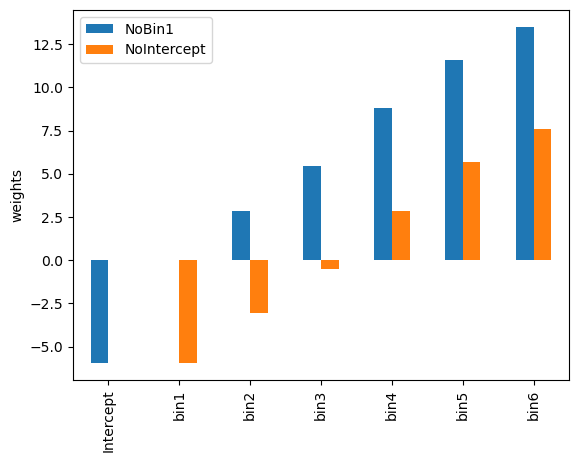

In [10]:
# converts weights for model without bin1 to dataframe
df1 = pd.DataFrame({'NoBin1':res_nobin1.params})

# converts weights for model without intercept to dataframe
df2 = pd.DataFrame({'NoIntercept':res_nointercept.params})

# join the two dataframes (missing values are filled with nans)
df_weights = df1.join(df2,how = 'outer')
                         
# plot
df_weights.plot.bar();
plt.ylabel('weights');

**How do the weights of the two models differ?**

*The value of the weights for bin1 in the no-intercept model is the same as the intercept in the no-bin1 model. For other bins, the weights differ by a constant term which corresponds to the intercept. In other words, the weight for binX in the no-intercept model is the sum of the corresponding weight and the intercept in the no-bin1 model. These two models are mathematically equivalent, but caution about how to interpret the bin weights: in one case, this is w.r.t to the weight of the reference value (no-bin1 model), while for the no-intercept model it is the raw value.*

## Checking for colinear or highly correlated regressors
Because we won't always remember to look for a possible note at the bottom of a summary to check whether our model makes sense, it is good to **perform checks prior to fitting**. Moreover, while colinearity is a fatal issue for regression models (unless we introduce priors or regularizers over weights, but we don't cover these during our course), **strong correlations between regressors can also severely damage our ability to interpret regression results**. Basically, if a linear combination of regressors is not exactly null but close enough to zero for all trials, then regressors can be estimated, but with a very large uncertainty.
This is why introducing too many regressors may lead to bad estimation through **overfitting**: as we add more and more regressors, we are bound to find *some* combination of regressors that is close enough to zero. This problem may be alleviated if we have a sufficiently large dataset.

The good news is that we can check *a priori* whether regressors are colinear or highly correlated using the **Variance Inflation Factor** (VIF). The VIF is a metric for each regressor in a regression model that determines how much estimation will be affected by correlation with other regressors (technically, how much the variance of the weight is inflated by the presence of the other regressors). Its value is always larger than 1, and the smaller the better. It is 1 if the regressor under study is completely uncorrelated to other regressors. It is infinite when regressors are colinear, and very large if the regressor is strongly correlated to others. A rule of thumb is that *if any VIF is larger than 5 (sometimes we see 10), then the model cannot be properly estimated and one regressor must be excluded.* But this is just a rule of thumb, how severe the problem is depends on the actual dataset. In any case, large VIFs should at minimum raise caution. 
VIFs can be computed using `variance_inflation_factor` from the `statsmodel` package.
**Check the VIF for the full set of stimulus bins as regressors.**

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# define the set of regressors we want to test independent variables set 
X = df[['bin1', 'bin2','bin3','bin4','bin5','bin6']]

# convert to array
X = X.values

# remember to add fixed regressor (for intercept)
fixed_regressor = np.ones((X.shape[0],1)) # 2D array with same number of lines as X and one column
X = np.concatenate((X,fixed_regressor),axis =1 )

vif= []
for i in range(nBin): # loop through bins
    # compute VIF for corresponding regressor
    V = variance_inflation_factor(X, i)
    vif.append(V)

    print("VIF for bin ", i+1, ": ", V)

VIF for bin  1 :  inf
VIF for bin  2 :  inf
VIF for bin  3 :  inf
VIF for bin  4 :  inf
VIF for bin  5 :  inf
VIF for bin  6 :  inf


C:\Users\alexa\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


We see that indeed VIF values are infinite, which denotes multicollinearity.
**Compute VIF values for the same set of regressors, excluding regressor for the first bin.**

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# define the set of regressors we want to test independent variables set 
df_sub = df[['bin2','bin3','bin4','bin5','bin6']]

# convert to array
X = df_sub.values

# remember to add fixed regressor (for intercept)
fixed_regressor = np.ones((X.shape[0],1))
X = np.concatenate((X,fixed_regressor),axis =1 )

vif= []
for i in range(nBin-1): # loop through bins
    # compute VIF for corresponding regressor
    V = variance_inflation_factor(X, i)
    vif.append(V)

    print("VIF for bin ", i+2, ": ", V)

VIF for bin  2 :  1.739723125052867
VIF for bin  3 :  2.3183521336707074
VIF for bin  4 :  1.926064272692391
VIF for bin  5 :  1.7397231250528675
VIF for bin  6 :  1.7390761548064917


**What do you conclude about this set of regressors?**

*The values of VIF are close to 2, which is clearly on the safe side (lower than 5). This shows that the model with this set of regressors is well defined.*

The function below allows to plot VIF values for variables in a dataframe (the intercept is added within the function).

In [13]:
def plot_vif(df):

    # VIF dataframe 
    VIF_df = pd.DataFrame() 
    VIF_df["regressor"] = df.columns 

    # convert to array
    X = df.values
    nReg = X.shape[1] # number of regressors

    # add fixed regressor (for intercept)
    fixed_regressor = np.ones((X.shape[0],1))
    X = np.concatenate((X,fixed_regressor),axis =1 )

    # calculating VIF for each feature 
    VIF_df["VIF"] = [variance_inflation_factor(X, i) 
                            for i in range(nReg)] 

    VIF_df.plot.barh(x='regressor',y='VIF');
    plt.xlabel('Variance Inflation Factor');
    plt.plot((1,1),(-1,nReg),'r');

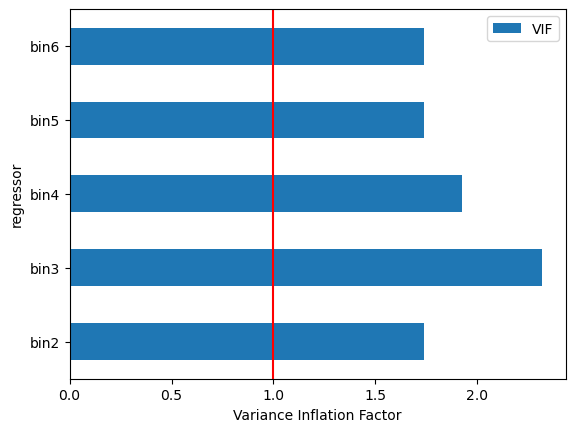

In [14]:
plot_vif(df_sub)

# Simulation-based power analysis
We are now fast rewinding and putting ourselves in the shoes of the experimenter *before* she actually starts collecting any data (well maybe these are actually your shoes).
How can I know **how many subjects to include in my sample to detect the effect of interest (if it is indeed present)**. This is the goal of *power analyses*. Statistical power refers to the probability that the effect, if present, is detected. The larger the better. The larger the sample size the larger the power. But we don't want to collect data from an infinite cohort of subjects either...
When your test of interest is a simple t-test or anova, then you can use a software ([G\*Power](https://www.psychologie.hhu.de/arbeitsgruppen/allgemeine-psychologie-und-arbeitspsychologie/gpower)) or online tools to run your power analyses. When you want to use the result of a more complex statistical analysis (as here), you can used simulation-based power analysis, which is presented in the panel B of the figure below (from [this](https://link.springer.com/article/10.3758/s13428-022-01793-9) little guide to behavioral experiments in humans we wrote).

![Task](https://media.springernature.com/full/springer-static/image/art%3A10.3758%2Fs13428-022-01793-9/MediaObjects/13428_2022_1793_Fig2_HTML.png)

Here **we will calculate the statistical power for detecting the confirmation bias in the dataset**. We will switch to the numerosity judgment dataset (of the same paper), the one we used in Assignment 2 to test for the confirmation bias.

The code below loads the data, changes the reference of the variable to 50, splits the second stimulus into two regressors `x2con` and `x2inc` depending on whether they are consistent with the intermediate binary classification performed by the subject. Just as we did in Assignment 2 (note that you don't really need to delve back into the intricacies of this regression model to follow the logic of the power analysis. It's just a linear regression model, that's about all we need to know.)

In [15]:
#load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A2_LinearRegression/Task_Numerical.csv",sep=',')

# use 50 as reference point
df.x1 = df.x1 - 50
df.x2 = df.x2 - 50
df.xavg = df.xavg - 50

# sign of x2
sgn = np.sign(df['x2'])

# define boolean array for consistency
consistent = sgn ==df['binchoice']

# add to dataframe
df['consistent'] = consistent

# x2con: equal to x2 if consistent, 0 otherwise
x2con = df['x2'] * consistent

# x2inc: equal to x2 if inconsistent, 0 otherwise 
x2inc = df['x2'] * ~consistent # could use (1-consistent) instead of ~consistent

# add as variables in dataframe
df['x2con'] = x2con
df['x2inc'] = x2inc

df.head()

,x1,binchoice,x2,xavg,estim,subj,consistent,x2con,x2inc
0,-4.625,-1,-8.375,-6.5000,44,1,True,-8.375,-0.000
1,-2.500,1,-11.375,-6.9375,41,1,False,-0.000,-11.375
2,-2.250,1,7.500,2.6250,54,1,True,7.500,0.000
3,-3.375,-1,-11.625,-7.5000,40,1,True,-11.625,-0.000
4,-2.750,-1,-8.625,-5.6875,45,1,True,-8.625,-0.000


Now if we want to run a simulation-based power analysis we need to be able to simulate the model. Makes sense. Here I adapted the code we used to simulate the simple linear regression model to the case of multiple regression (so multiple regressors).

In [16]:
#import function
from numpy.random import normal

# define function that simulates the linear regression model
def generate_multiple_linear_model(x, intercept, weights, sigma):
    """
    Simulates a multiple linear model 
    Args:
       X (array): value(s) of the regressor
       intercept (float): intercept
       weights (array): weights for all regressors
       sigma (float): standard deviation of noise parameter
    """  
    # use linear relationship (using matrix multiplication)
    y = intercept + np.matmul(x,weights)
    
    # add gaussian noise with standard deviation=sigma
    n = x.shape[0]
    y = y + sigma*normal(size=n)
    
    # output the result
    return y

**Let us simulate the model**. For this, we need to specify model parameters. This is the weak part of power analysis: you need to know the true values of the model parameters to know how likely you are to detect an effect... sounds a bit circular. So, in general we use plausible values, either from the literature or from pilot participants. The most crucial choice is the strength of the effect (so here the difference between the weights of the second stimulus when it's consistent vs. inconsistent with the intermediate choice, `w_x2con` and `w_x2inc`). Needless to say, the larger this difference, the more probable it is to be detected statistically. Here we test with a difference of .1: that is if the weight of the second stimulus on the participant estimate is 0.5 if it is consistent with the first, and 0.4 otherwise.

In [17]:
effect_size = .1 # size of difference between weights of second stimulus depending on its consistency with intermediate choice
w_x1 = .5 # weight for the first stimulus
w_x2con = .5 # weight for the second stimulus, if consistent
w_x2inc = .5 - effect_size # weight for the second stimulus, if inconsistent
intercept = 50 # intercept (50 because this is the reference point, corresponds to an unbiased model)

sigma = 5 # value of the gaussian noise

weights = [w_x1,w_x2con,w_x2inc] # array of weights

# define design matrix, i.e. put all regressors into a numpy array
X = df[['x1','x2con','x2inc']]
X = X.to_numpy()

# simulate!
y_simul = generate_multiple_linear_model(X, intercept, weights, sigma)

Simulation is the first part of the process. The second part is **fitting the regression model on the simulated data and applying the exact same statistical test that we want to apply on the true experimental data**. Here the test was a paired t-test between the set of consistent/inconsistent weights for the second stimulus, across subjects. I have copied the code from Assignment 2 into a function that takes an experimental dataframe (either from experimental or simulated data) as input and spits out the p-value for the corresponding test. Basically it tells us whether the effect is statistically significant in any dataset.

In [18]:
# Importing library 
import scipy.stats as stats

# define function that provides p-value for effect of confirmation bias in given dataset
def fit_confirmation_bias_model(df):
    """
    Fits the regression model for confirmation bias 
    Args:
       df (dataframe): experimental dataset
    """  

    # list of subjects
    subjects = np.unique(df.subj)

    # create array for weights for each subject (how many weights per subject?)
    pars = np.zeros((len(subjects),4))

    # loop through all subjects
    for i,s in enumerate(subjects):

        # dataframe for this subject
        df_subj = df[df.subj==s]

        # define and fit regression model
        mod = ols(formula = 'estim ~ x1 + x2con + x2inc', data=df_subj)
        res = mod.fit()

        # store values of the parameters
        pars[i,:] = res.params

    # compute mean across subjects
    mean_weights = np.mean(pars,axis=0)

    T = stats.ttest_rel(pars[:,2], pars[:,3]) 

    return  T.pvalue, pars

Now let us plug the two processes: we fit the regression models on the synthetic dataset (from simulations) and compute the corresponding p-value.

In [19]:
# copy the experimental dataframe
df_simul = df

# copy the value of the simulated model as if it were the estimation from the subject
df_simul['estim'] = y_simul

# compute the pvalue for the confirmation bias on this dataset
pval, est_weights = fit_confirmation_bias_model(df_simul)

print("p-value",pval)

p-value 0.03254978252601831


Great! We're almost there. You can simulate the model again by running the corresponding cell above and see that the p-value is different everytime. Sometimes it is significant, but not always. Let us do it in a consistent way: **build a function that repeatedly simulates a synthetic dataset and estimate the significance of the confirmation bias in this synthetic dataset, and outputs the collection of p-values for all simulated datasets**.

In [20]:
# function that simulates and fits model multiple time
def simulate_and_fit_confirmation_bias_model(df, intercept, weights, sigma, nSimul=100):
    """
    Simulates and test for the confirmation bias, for a given number of synthetic dataset
    Args:
       df (dataframe): experimental dataset
       intercept (float): value of intercept
       weights (array of 3): value of the weights
       sigma (float): std of observation noise (gaussian)
       nSimul (integer): number of datasets
    """  
    # p-values for all datasets
    all_pvalues = []
    for s in range(nSimul): # for all datasets
        
        # simulate model
        y_simul = generate_multiple_linear_model(X, intercept, weights, sigma)

        # add simulated behavior as dependent variable in the dataframe
        df['estim'] = y_simul
        
        # test for confirmation bias in the dataset
        pval, _ = fit_confirmation_bias_model(df)

        # add p-value
        all_pvalues.append(pval)
        
    all_pvalues = np.array(all_pvalues) # convert to numpy
    return all_pvalues

Ok, let's run this (this should take around a minute or so)! **Plot the histogram of p-values and add a vertical line for the significance criterion (at 0.05)**.

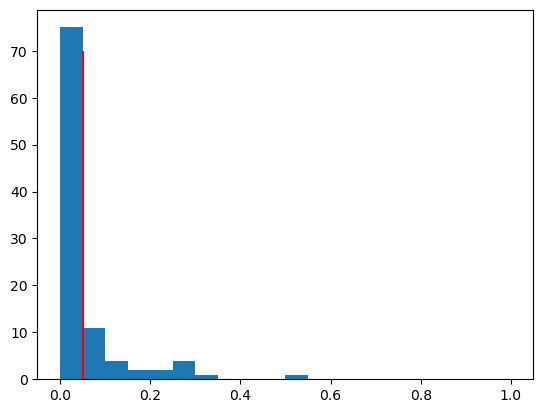

In [21]:
# simulate all datasets and compute corresponding p-values
all_p = simulate_and_fit_confirmation_bias_model(df, intercept, weights, sigma,nSimul=100)

# add histogram
bins = .05*np.arange(21) # bins: 0, 0.05, .1, ...
plt.hist(all_p, bins=bins);

# add vertical line
plt.vlines(.05,0, 70,color='r');

Finally, **compute the statistical power for this analysis**, i.e. the proportion of simulations that yield a significant effect.

In [22]:
# define boolean array for significance
signif = (all_p < .05)

# compute power (i.e average of significant datasets)
power = np.mean(signif)

print("statistical power: ", 100*power, "%")

statistical power:  75.0 %


**How do you interpret this result?**

*According to our simulations, if the effect is present with the same size as given by the parameters, there is about 75% probability to detect it in a 21-subject cohort (same as true experimental dataset). In general, we aim at statistical powers about 80-90% to maximize our chance to not miss the effect we're after.*

**Check that the statistical power decreases if you decrease the effect size, and increase if your increase it.**

Mixed models are not very well developed in Python. The R language is better adapted for many advanced statistics methods. You have two choices:
1) Use the function *mixedlm* in the Python library **statsmodels.formula.api**. The syntax is similar to linear regression in **statsmodel**. There are more sophisticated mixed models with the [bambi](https://bambinos.github.io/bambi/) package.

2) Use the Python library **pymer4.models**, which gives you access to R functions from within Python. You can then import the *Lmer* package (or other mixed-effects modelling packages) and call it specifying the fixed and random factors in your design (check the documentation).

1) Let us **implement a linear mixed model where the random factor for the intercept of each participant**. This is very similar to a traditional linear regression model with subject-specific biases (i.e. adding `C(subj)` in the formula), except that now we directly estimate the distribution of biases across the population, rather than each subject bias.

In [23]:
# import package
from statsmodels.formula.api import mixedlm

# define model: 
# - the fixed effects are given in the formula as for ols
# - the random factor is defined by 'groups' (variable 'subj')
# - the random effects (which weights should vary per subject) is defined by re_formula (here, just the intercept so "~1")
mod_sub = mixedlm(formula='estim ~ x1 + x2', data=df, groups=df['subj'], re_formula="~1")

# fit the model
res_sub = mod_sub.fit(maxiter=500,method="nm", reml="false")

# show summary
res_sub.summary()

C:\Users\alexa\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: estim     
No. Observations: 1738    Method:             REML      
No. Groups:       21      Scale:              24.9776   
Min. group size:  72      Log-Likelihood:     -5267.8583
Max. group size:  84      Converged:          Yes       
Mean group size:  82.8                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    50.106    0.124 403.851 0.000 49.863 50.349
x1            0.560    0.034  16.439 0.000  0.493  0.627
x2            0.455    0.017  26.631 0.000  0.422  0.489
Group Var     0.000    0.020                            
========================================================

"""

This model gives us a similar result to what we got when we modeled subjects as fixed factors in Assignment 2. But actually subjects will differ not only because of their overall bias, but also because of a different weighting of stimulus information. So a better model will incorporate this variability, by adding the first and second stimuli as random factors.

In [24]:
from statsmodels.formula.api import mixedlm

# same as above, but now the random effects include x1 and x2
mod_sub = mixedlm(formula='estim ~ x1 + x2', data=df, groups=df['subj'], re_formula="~x1+x2")
res_sub = mod_sub.fit(maxiter=500,method="nm", reml="false")

res_sub.summary()

C:\Users\alexa\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: estim     
No. Observations:   1738    Method:             REML      
No. Groups:         21      Scale:              24.8317   
Min. group size:    72      Log-Likelihood:     -5267.1172
Max. group size:    84      Converged:          Yes       
Mean group size:    82.8                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      50.105    0.131 382.690 0.000 49.848 50.362
x1              0.560    0.037  15.327 0.000  0.488  0.632
x2              0.455    0.018  24.675 0.000  0.419  0.491
Group Var       0.038    0.034                            
Group x x1 Cov  0.007    0.006                            
x1 Var          0.004    0.002                            
Group x x2 Cov  0.004    0.005                            
x1 x x2 Cov     0.002    0.001                            
x2 Var          0.001    0.001                            
==========================================================

"""

2) we can repeat this analysis using the other method, which calls R from Python. Convince yourself that the results are similar (Note: installing pymer 4 may not work on all distributions).

In [25]:
from pymer4.models import Lmer

model = Lmer('estim ~ x1 + x2 + (1 + x1 + x2|subj)', data=df)
res = model.fit()
print(res)

ModuleNotFoundError: No module named 'pymer4'